# LSTM

In [1]:
#import packages
import numpy as np
from numpy import *
from numpy.random import *
import matplotlib.pyplot as plt
import random
import math
from datetime import datetime
import pickle
import pandas as pd
%matplotlib inline

#predefined activation function and its derivative
def Sigmoid(x): 
    return 1. / (1 + np.exp(-x))

def dSigmoid(values): 
    return values*(1-values)

def Tanh(x):
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def dtanh(values): 
    return 1. - values**2

def rand_arr(a, b, *args): 
    seed(0)
    return rand(*args)*(b - a) + a

#LSTM Class
class LSTM:
    def __init__(self, X_dim, y_dim, neuron):
        
        self.X_dim = X_dim 
        self.y_dim = y_dim
        self.neuron = neuron
        
        #initiate weight
        self.weight_f = rand_arr(-0.1, 0.1, neuron, X_dim + neuron)
        self.weight_i = rand_arr(-0.1, 0.1, neuron, X_dim + neuron)
        self.weight_g = rand_arr(-0.1, 0.1, neuron, X_dim + neuron) 
        self.weight_o = rand_arr(-0.1, 0.1, neuron, X_dim + neuron)
        self.weight_out = rand_arr(-0.1, 0.1, y_dim, neuron)
        
        #initiate bias
        self.bias_f = rand_arr(-0.1, 0.1, neuron) 
        self.bias_i = rand_arr(-0.1, 0.1, neuron) 
        self.bias_g = rand_arr(-0.1, 0.1, neuron) 
        self.bias_o = rand_arr(-0.1, 0.1, neuron)
        self.bias_out = rand_arr(-0.1, 0.1, y_dim)
    
    def forward(self, inputs, outputs):
        X = inputs
        y = outputs
        
        self.X = X
        self.y = y
        #make list to save the values of every unit 
        self.X_concat = []
        self.f = []
        self.i = []
        self.g = []
        self.o = []
        self.s = [zeros(self.neuron)] #first s input is 0
        self.h = [zeros(self.neuron)] #first h input is 0
        self.out = []
        self.error = []
        for i in range(len(inputs)):
            #forward for every unit
            X_concat = np.hstack((X[i],  self.h[i]))
            self.X_concat.append(X_concat)
            self.f.append(Sigmoid(self.weight_f@X_concat + self.bias_f))
            self.i.append(Sigmoid(self.weight_i@X_concat + self.bias_i))
            self.g.append(Tanh(self.weight_g@X_concat + self.bias_g))
            self.o.append(Sigmoid(self.weight_o@X_concat + self.bias_o))
            self.s.append(self.f[i]*self.s[i] + self.i[i]*self.g[i])
            self.h.append(Tanh(self.s[i+1])*self.o[i])
            self.out.append(self.weight_out@self.h[i+1] + self.bias_out)
            self.error.append(abs(self.out[-1] - y[i]))
        #show error
        #print(np.array(self.error).mean())
    
    def backward(self, inputs, outputs):
        self.diff_out = []
        self.diff_h = []
        self.diff_h_bottom = [zeros(self.neuron)]
        self.diff_s_up = [zeros(self.neuron)]
        self.diff_s = []
        self.diff_o = []
        self.diff_g = []
        self.diff_i = []
        self.diff_f = []
        for i in range(len(inputs)-1,-1,-1):
            #derivate of output
            if i == len(inputs)-1:
                self.diff_out  = [2*(self.out[i] - outputs[i])] + self.diff_out
                self.diff_h = [self.diff_out[0]*dSigmoid(self.weight_out@self.h[i+1] + self.bias_out)*self.weight_out + self.diff_h_bottom[0]] + self.diff_h
            else:
                self.diff_h = [self.diff_h_bottom[0]] + self.diff_h
            
            
            #derivative of gate/neural network operation
            self.diff_s = [self.diff_h[0]*self.o[i]*dtanh(self.s[i+1]) + self.diff_s_up[0]] + self.diff_s
            self.diff_o = [self.diff_h[0]*Tanh(self.s[i+1])] + self.diff_o
            self.diff_g = [self.i[i]*self.diff_s[0]] + self.diff_g
            self.diff_i = [self.g[i]*self.diff_s[0]] + self.diff_i
            self.diff_f = [self.s[i]*self.diff_s[0]] + self.diff_f
            
            #derivative of concatenation of input dan previous output value
            self.dX_concat = (self.diff_o[0].T*(dSigmoid(self.o[i]).reshape(self.neuron,1))).T@self.weight_o
            self.dX_concat += (self.diff_g[0].T*(dSigmoid(self.g[i]).reshape(self.neuron,1))).T@self.weight_g
            self.dX_concat += (self.diff_i[0].T*(dSigmoid(self.i[i]).reshape(self.neuron,1))).T@self.weight_i
            self.dX_concat += (self.diff_f[0].T*(dSigmoid(self.f[i]).reshape(self.neuron,1))).T@self.weight_f
            
            #update value of long and short term memory
            self.diff_h_bottom = [self.dX_concat[-1][self.X_dim:]] + self.diff_h_bottom
            self.diff_s_up = [self.diff_s[0]*self.f[i]] + self.diff_s_up
            
    def update(self, alpha):
        
        #alpha 
        
        #update everyweight and bias
        self.weight_out -= alpha*self.diff_out[0].reshape(1,1)@self.h[1].T.reshape(1,self.neuron)
        self.bias_out -= alpha*self.diff_out[0]
        
        self.weight_f -= alpha*(self.diff_f[0]*dSigmoid(self.weight_f@self.X_concat[0] + self.bias_f)).T@self.X_concat[0].reshape(1,self.X_dim + self.neuron)
        self.bias_f -= alpha*(self.diff_f[0]*dSigmoid(self.weight_f@self.X_concat[0] + self.bias_f)).reshape(self.neuron,)
        
        self.weight_i -= alpha*(self.diff_i[0]*dSigmoid(self.weight_i@self.X_concat[0] + self.bias_i)).T@self.X_concat[0].reshape(1,self.X_dim + self.neuron)
        self.bias_i -= alpha*(self.diff_i[0]*dSigmoid(self.weight_i@self.X_concat[0] + self.bias_i)).reshape(self.neuron,)
        
        self.weight_g -= alpha*(self.diff_g[0]*dSigmoid(self.weight_g@self.X_concat[0] + self.bias_g)).T@self.X_concat[0].reshape(1,self.X_dim + self.neuron)
        self.bias_g -= alpha*(self.diff_g[0]*dSigmoid(self.weight_g@self.X_concat[0] + self.bias_g)).reshape(self.neuron,)
        
        self.weight_o -= alpha*(self.diff_o[0]*dSigmoid(self.weight_o@self.X_concat[0] + self.bias_o)).T.reshape(self.neuron,1)@self.X_concat[0].reshape(1,self.X_dim + self.neuron)
        self.bias_o -= alpha*(self.diff_o[0]*dSigmoid(self.weight_o@self.X_concat[0] + self.bias_o)).reshape(self.neuron,)
    
    def predict(self, inputs, outputs):
        X = inputs
        y = outputs
        self.X = X
        self.y = y
        #make list to save the values of every unit 
        self.X_concat = []
        self.f = []
        self.i = []
        self.g = []
        self.o = []
        self.s = [zeros(self.neuron)] #first s input is 0
        self.h = [zeros(self.neuron)] #first h input is 0
        self.out = []
        self.error = []
        for i in range(len(inputs)):
            #forward for every unit
            X_concat = np.hstack((X[i],  self.h[i]))
            self.X_concat.append(X_concat)
            self.f.append(Sigmoid(self.weight_f@X_concat + self.bias_f))
            self.i.append(Sigmoid(self.weight_i@X_concat + self.bias_i))
            self.g.append(Tanh(self.weight_g@X_concat + self.bias_g))
            self.o.append(Sigmoid(self.weight_o@X_concat + self.bias_o))
            self.s.append(self.f[i]*self.s[i] + self.i[i]*self.g[i])
            self.h.append(Tanh(self.s[i+1])*self.o[i])
            self.out.append(self.weight_out@self.h[i+1] + self.bias_out)
            self.error.append(abs(self.out[-1] - y[i]))
        
        return [self.out[-1][0],self.y[-1]]
    
    def show_progress(self):
        return abs(self.y[-1][0] - self.out[-1])

# Change the Indicators Here!

In [21]:
#hyperparameters
epochs  = 1000
nc      = 100 #units

#datasets
name_of_dataset = 'GGRM-short.csv'
name_dataset = 'GGRM-short'

column_dataset_obs = 'Close'

# Import Dataset

In [3]:
df = pd.read_csv('../../Datasets/'+name_of_dataset)
df.drop('Volume', inplace=True, axis=1)
df

,Date,Open,High,Low,Close,Adj Close
0,2017-01-02,63900.0,63900.0,63900.0,63900.0,53824.433594
1,2017-01-03,63650.0,64350.0,63100.0,63300.0,53319.042969
2,2017-01-04,63400.0,64450.0,62300.0,63200.0,53234.804688
3,2017-01-05,63200.0,65600.0,63200.0,65600.0,55256.382813
4,2017-01-06,65450.0,65450.0,63900.0,64425.0,54266.652344
...,...,...,...,...,...,...
58,2017-03-23,65800.0,65950.0,65400.0,65450.0,55130.031250
59,2017-03-24,65025.0,65600.0,64850.0,64925.0,54687.816406
60,2017-03-27,64500.0,65225.0,64400.0,64500.0,54329.828125
61,2017-03-29,64500.0,65500.0,64500.0,65500.0,55172.152344


In [4]:
df.describe()

,Open,High,Low,Close,Adj Close
count,63.000000,63.000000,63.000000,63.000000,63.000000
mean,63495.634921,63944.841270,62941.666667,63434.920635,53432.686260
std,1452.018476,1428.985363,1334.884011,1476.615707,1243.786853
min,60150.000000,60525.000000,60050.000000,60150.000000,50665.722656
25%,62550.000000,63025.000000,62075.000000,62500.000000,52645.183594
50%,63475.000000,63900.000000,62925.000000,63200.000000,53234.804688
75%,64500.000000,65150.000000,63900.000000,64487.500000,54319.298828
max,66700.000000,66700.000000,65400.000000,66700.000000,56182.933594


In [5]:
new_df = df.reset_index()[column_dataset_obs]
new_df

0     63900.0
1     63300.0
2     63200.0
3     65600.0
4     64425.0
       ...   
58    65450.0
59    64925.0
60    64500.0
61    65500.0
62    66700.0
Name: Close, Length: 63, dtype: float64

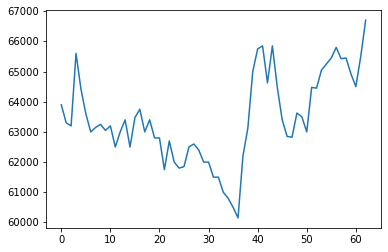

In [6]:
plt.plot(new_df)

# MinMax Scaler

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
new_df = scaler.fit_transform(np.array(new_df).reshape(-1,1))
# new_df

In [8]:
xs = new_df

In [9]:
#Standarized the dataset
N       = xs.shape[0]

#hypreparameter
Ts      = 1
x_dim   = 1
alpha   = 0.01 #learningrate

xt      = xs[0:N-x_dim,:]

for i in range(x_dim):
    xt  = hstack((xt, xs[i+1:N-x_dim+i+1]))   



# Splitting Training and Testing

In [10]:
training_size = int(len(new_df)*0.8)
test_size = len(new_df)-training_size

In [11]:
training_size, test_size

(50, 13)

In [12]:
X_train = xt[:training_size, 0:x_dim]     
y_train = xt[:training_size, x_dim:x_dim+1]  
X_test = xt[-test_size:, 0:x_dim]     
y_test = xt[-test_size:, x_dim:x_dim+1]

## Build LSTM Model

In [13]:
me = LSTM(x_dim,1,nc)
for i in range(epochs):
    print('-------------',i+1,'-------------')
    for j in range(X_train.shape[0]-Ts):
        me.forward(X_train[j:j+Ts],y_train[j:j+Ts])
        me.backward(X_train[j:j+Ts],y_train[j:j+Ts])
        me.update(alpha)
    hehe = []
    for j in range(X_test.shape[0]-Ts):
        me.forward(X_test[j:j+Ts],y_test[j:j+Ts])
        me.backward(X_test[j:j+Ts],y_test[j:j+Ts])
        me.update(alpha)
        hehe.append(me.show_progress())    
    print(np.array(hehe).mean())

------------- 1 -------------
0.37889074354853874
------------- 2 -------------
0.2764673309857785
------------- 3 -------------
0.25124219655994745
------------- 4 -------------
0.24438888474857348
------------- 5 -------------
0.24230537370950103
------------- 6 -------------
0.24157044292095176
------------- 7 -------------
0.24121689404716454
------------- 8 -------------
0.24097129549704913
------------- 9 -------------
0.24075634662022835
------------- 10 -------------
0.2405501935911235
------------- 11 -------------
0.24034665750216555
------------- 12 -------------
0.24014399075462467
------------- 13 -------------
0.23994169847936428
------------- 14 -------------
0.23973963995363842
------------- 15 -------------
0.23953777457314973
------------- 16 -------------
0.2393360900391089
------------- 17 -------------
0.239134582057007
------------- 18 -------------
0.23893324859753862
------------- 19 -------------
0.23873208827417267
------------- 20 -------------
0.238531099884

0.20991946912243029
------------- 170 -------------
0.20973276035896582
------------- 171 -------------
0.20954607758309907
------------- 172 -------------
0.20935941999127086
------------- 173 -------------
0.20917278678287662
------------- 174 -------------
0.20898617716029308
------------- 175 -------------
0.20879959032890694
------------- 176 -------------
0.20861302549714256
------------- 177 -------------
0.20842648187649018
------------- 178 -------------
0.20823995868153442
------------- 179 -------------
0.2080534551299825
------------- 180 -------------
0.20786697044269375
------------- 181 -------------
0.20768050384370787
------------- 182 -------------
0.20749405456027403
------------- 183 -------------
0.2073076218228814
------------- 184 -------------
0.20712120486528693
------------- 185 -------------
0.20693480292454605
------------- 186 -------------
0.20674841524104268
------------- 187 -------------
0.20656204105851828
------------- 188 -------------
0.206375679624

0.17842051563371486
------------- 338 -------------
0.17823020030823997
------------- 339 -------------
0.17803984197592695
------------- 340 -------------
0.17784944076982553
------------- 341 -------------
0.17765899683081574
------------- 342 -------------
0.17746851030762115
------------- 343 -------------
0.1772779813568199
------------- 344 -------------
0.1770874101428567
------------- 345 -------------
0.17689679683805346
------------- 346 -------------
0.1767061416226198
------------- 347 -------------
0.1765154446846632
------------- 348 -------------
0.176324706220199
------------- 349 -------------
0.17613392643315828
------------- 350 -------------
0.1759431055353983
------------- 351 -------------
0.17575224374670947
------------- 352 -------------
0.17556134129482315
------------- 353 -------------
0.17537039841541993
------------- 354 -------------
0.17517941535213497
------------- 355 -------------
0.1749883923565657
------------- 356 -------------
0.17479732968827655


0.14600698078116403
------------- 507 -------------
0.1458173215921264
------------- 508 -------------
0.14562774565995365
------------- 509 -------------
0.14543825419818066
------------- 510 -------------
0.14524884842276584
------------- 511 -------------
0.14505952955202217
------------- 512 -------------
0.14487029880654637
------------- 513 -------------
0.14468115740914833
------------- 514 -------------
0.1444921065847813
------------- 515 -------------
0.14430314756047
------------- 516 -------------
0.14411428156524075
------------- 517 -------------
0.14392550983004973
------------- 518 -------------
0.1437368335877123
------------- 519 -------------
0.14354825407283087
------------- 520 -------------
0.14335977252172466
------------- 521 -------------
0.1431713901723571
------------- 522 -------------
0.14298310826426464
------------- 523 -------------
0.14279492803848495
------------- 524 -------------
0.14260685073748486
------------- 525 -------------
0.1424188776050889


0.11609889344277523
------------- 676 -------------
0.11594017124369294
------------- 677 -------------
0.11578171834387711
------------- 678 -------------
0.11562353546090638
------------- 679 -------------
0.11546562330569814
------------- 680 -------------
0.11530798258249457
------------- 681 -------------
0.11515061398884757
------------- 682 -------------
0.11499351821560556
------------- 683 -------------
0.11483669594689898
------------- 684 -------------
0.11468014786012888
------------- 685 -------------
0.11452387462595377
------------- 686 -------------
0.11436787690827799
------------- 687 -------------
0.11421215536424101
------------- 688 -------------
0.11405671064420615
------------- 689 -------------
0.11390154339175114
------------- 690 -------------
0.11374665424365793
------------- 691 -------------
0.11359204382990402
------------- 692 -------------
0.11343771277365368
------------- 693 -------------
0.11328366169125037
------------- 694 -------------
0.1131298911

0.09521006048649217
------------- 843 -------------
0.09514564702768809
------------- 844 -------------
0.09508141044818445
------------- 845 -------------
0.09501735058725587
------------- 846 -------------
0.09495346728182774
------------- 847 -------------
0.09488976036649362
------------- 848 -------------
0.09482622967353432
------------- 849 -------------
0.09476287503293501
------------- 850 -------------
0.09469969627240471
------------- 851 -------------
0.09463669321739321
------------- 852 -------------
0.09457386569111019
------------- 853 -------------
0.0945112135145431
------------- 854 -------------
0.09444873650647474
------------- 855 -------------
0.09438643448350252
------------- 856 -------------
0.09432430726005547
------------- 857 -------------
0.09426235464841326
------------- 858 -------------
0.09420057645872337
------------- 859 -------------
0.09413897249901997
------------- 860 -------------
0.09407754257524174
------------- 861 -------------
0.09401628649

In [14]:
import matplotlib.pyplot as plt

out = []
for j in range(X_test.shape[0]-Ts):
    out.append(me.predict(X_test[j:j+Ts],y_test[j:j+Ts]))

out=scaler.inverse_transform(out).tolist()

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


## Report Performance of LSTM Predictions

In [15]:
from math import sqrt

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [16]:
# mse = mean_squared_error(y, predictions)
# print('MSE: '+str(mse))
print('epoch: ' + str(epochs))
print('units: ' + str(nc))

rmse = math.sqrt(mean_squared_error(np.array(out)[:,1], np.array(out)[:,0]))
print('RMSE: '+ str("{:.2f}".format(rmse)))
mae = mean_absolute_error(np.array(out)[:,1], np.array(out)[:,0])
print('MAE: '+ str("{:.2f}".format(mae)))
mape = mean_absolute_percentage_error(np.array(out)[:,1], np.array(out)[:,0])
print('MAPE: '+ str("{:.2f}".format(mape*100)))

epoch: 1000
units: 100
RMSE: 655.72
MAE: 534.68
MAPE: 0.82


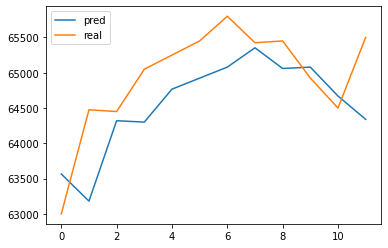

In [17]:
plt.plot(np.array(out)[:,0],label = 'pred')
plt.plot(np.array(out)[:,1],label = 'real')
plt.legend()

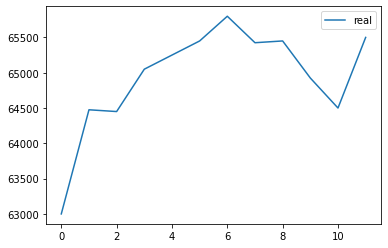

In [18]:

plt.plot(np.array(out)[:,1],label = 'real')
plt.legend()

In [20]:
out

[[63565.697614487915, 63000.0],
 [63181.24527579992, 64475.0],
 [64319.92349142525, 64450.0],
 [64300.51511610235, 65049.99999999999],
 [64767.232340063594, 65250.00000000001],
 [64923.20892496023, 65450.0],
 [65079.37426002064, 65800.0],
 [65353.093823638665, 65425.00000000001],
 [65059.843543476876, 65450.0],
 [65079.37426002064, 64925.00000000001],
 [64669.84637475155, 64500.0],
 [64339.335301551975, 65500.0]]

## Save as a new Dataset

In [29]:
new_data = {'Close_LSTM': np.array(out)[:,1],
            'real_price': np.array(out)[:,0]}

In [30]:
df_new_data = pd.DataFrame(new_data, columns = ['real_price', 'Close_LSTM'])

print(df_new_data)

      real_price  Close_LSTM
0   63565.697614     63000.0
1   63181.245276     64475.0
2   64319.923491     64450.0
3   64300.515116     65050.0
4   64767.232340     65250.0
5   64923.208925     65450.0
6   65079.374260     65800.0
7   65353.093824     65425.0
8   65059.843543     65450.0
9   65079.374260     64925.0
10  64669.846375     64500.0
11  64339.335302     65500.0


In [32]:
df_new_data.to_csv('../../Datasets/dataset after prediction/'+name_dataset
                   +'_LSTM_'+ str(epochs) +'_'+ str(nc) + '.csv', index=False)

## Save as a new Dataset